In [1]:
import requests

import pandas as pd
import matplotlib.pyplot as plt

# Get model params

In [16]:
%%timeit
requests.post("http://127.0.0.1:2021/get_model_states_params", json={"model_name": "BR"})

124 ms ± 15.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
r = requests.post("http://127.0.0.1:2021/get_model_states_params", json={"model_name": "BR"})

In [18]:
params = pd.DataFrame(r.json()["params"]).set_index(["component", "variable"])["value"]
states = pd.DataFrame(r.json()["states"]).set_index(["component", "variable"])["value"]

In [19]:
params

component            variable          
sodium_current       g_Na                      0.04000
                     E_Na                     50.00000
                     g_Nac                     0.00003
stimulus_protocol    IstimStart               10.00000
                     IstimEnd              50000.00000
                     IstimAmplitude            0.50000
                     IstimPeriod            1000.00000
                     IstimPulseDuration        1.00000
slow_inward_current  g_s                       0.00090
membrane             C                         0.01000
Name: value, dtype: float64

In [20]:
states

component                               variable
slow_inward_current_d_gate              d            0.0030
slow_inward_current_f_gate              f            0.9940
slow_inward_current                     Cai          0.0001
time_dependent_outward_current_x1_gate  x1           0.0001
sodium_current_m_gate                   m            0.0110
sodium_current_h_gate                   h            0.9880
membrane                                V          -84.6240
sodium_current_j_gate                   j            0.9750
Name: value, dtype: float64

# kwargs

In [21]:
kwargs_problem_keys = ["u0", "p", "tspan"]

In [22]:
kwargs_output_keys = ["saveat", "tstops"]  # and other ...
kwargs_stepping_keys = ["abstol", "reltol", "dt", "dtmax", "dtmin"]  # and others ...
# kwargs_misc_keys = ["callback"]

kwargs_solve_keys = ["solver"] + kwargs_output_keys + kwargs_stepping_keys

# Example

In [23]:
params.loc[("stimulus_protocol", "IstimStart")] = 0.
params.loc[("sodium_current", "g_Na")] = 0.04 * 0.5
params.loc[("slow_inward_current", "g_s")] = 0.0009 * 1.5

params

component            variable          
sodium_current       g_Na                      0.02000
                     E_Na                     50.00000
                     g_Nac                     0.00003
stimulus_protocol    IstimStart                0.00000
                     IstimEnd              50000.00000
                     IstimAmplitude            0.50000
                     IstimPeriod            1000.00000
                     IstimPulseDuration        1.00000
slow_inward_current  g_s                       0.00135
membrane             C                         0.01000
Name: value, dtype: float64

In [24]:
# example

req_dict = {"model_name": "BR",
            "kwargs_problem": {"p": params.to_list(), "tspan": [1e-9, 2000]},  # 0.0 casts to 0 in the request body, FIX THIS
            "kwargs_solve": {"solver": "CVODE_BDF", "dt": 1e-5, "dtmax": 0.5}}
req_dict

{'model_name': 'BR',
 'kwargs_problem': {'p': [0.02,
   50.0,
   3e-05,
   0.0,
   50000.0,
   0.5,
   1000.0,
   1.0,
   0.00135,
   0.01],
  'tspan': [1e-09, 2000]},
 'kwargs_solve': {'solver': 'CVODE_BDF', 'dt': 1e-05, 'dtmax': 0.5}}

# Solve model

In [25]:
%%timeit
requests.post("http://127.0.0.1:2021/solve_cellml_model", json=req_dict)

159 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [26]:
r = requests.post("http://127.0.0.1:2021/solve_cellml_model", json=req_dict)

In [27]:
response = r.json()

In [28]:
def solution_to_dataframe(response):
    data = {x["variable"]: x["value"] for x in response["solution"]}
    df = pd.DataFrame(data)
    return df

In [29]:
df = solution_to_dataframe(response)
t = response["time"]

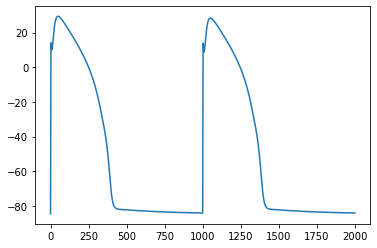

In [30]:
plt.plot(t, df["V"])